In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score


In [2]:
BLURRINESS_THRESHOLD = 1.2805228893466365

In [3]:
def get_mask_generator(mask_generator):
    if mask_generator == "rectangular":
        return rectangular_mask
    elif mask_generator == "circular":
        return circular_mask
    else:
        raise ValueError("Mask generator (-m/--mask-generator) must be either 'rectangular' or 'circular'.")


def run_single(image, filter_threshold, mask_generator, visualize, save_reconstructed = False):
    filtered_image = get_filtered_image(image, filter_threshold, get_mask_generator(mask_generator), visualize)
    if save_reconstructed:
        reconstructed_image_name = save_image_name(image)
        reconstructed_image = 255-np.abs(filtered_image)
        plt.imsave(reconstructed_image_name, reconstructed_image, cmap="gray")

        
def run_batch(folder, mask_generator, filter_thresholds):
    images_names = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    return get_and_save_detect_blur_data(images_names, filter_thresholds, get_mask_generator(mask_generator))

    
def circular_mask(height, width, r):
    mask = np.ones((height, width))
    center = (int(height/2), int(width/2))
    x, y = np.ogrid[:height,:width]
    mask_area = (x - center[0])**2 + (y - center[1])**2 <= r**2
    mask[mask_area] = 0
    return mask


def rectangular_mask(height, width, side):
    mask = np.ones((height, width))
    center = (int(height/2), int(width/2))
    mask[center[0]-side:center[0]+side, center[1]-side:center[1]+side] = 0
    return mask


def apply_high_pass_filter(image, frequency_threshold, mask_generator=rectangular_mask, visualize=False):
    height, width = image.shape
    cX, cY = (int(width/2.0), int(height/2.0))

    transformed_image = np.fft.fft2(image)
    transformed_and_shifted_image = np.fft.fftshift(transformed_image)

    mask = mask_generator(height, width, frequency_threshold)

    transformed_and_shifted_image_filtered = transformed_and_shifted_image * mask
    transformed_image_filtered = np.fft.ifftshift(transformed_and_shifted_image_filtered)
    reconstructed_image = np.fft.ifft2(transformed_image_filtered)

    if visualize:
        # compute the magnitude spectrum of the transform
        magnitude = 20 * np.log(np.abs(transformed_image))
        shifted_magnitude = 20 * np.log(np.abs(transformed_and_shifted_image))
        # display the original input image
        (fig, ax) = plt.subplots(2, 3, )
        ax[0,0].imshow(image, cmap="gray")
        ax[0,0].set_title("Input")
        ax[0,0].set_xticks([])
        ax[0,0].set_yticks([])
        # display the magnitude image
        ax[0,1].imshow(magnitude, cmap="gray")
        ax[0,1].set_title("Magnitude Spectrum")
        ax[0,1].set_xticks([])
        ax[0,1].set_yticks([])
        # display the magnitude image
        ax[0,2].imshow(shifted_magnitude, cmap="gray")
        ax[0,2].set_title("Shifted Magnitude Spectrum")
        ax[0,2].set_xticks([])
        ax[0,2].set_yticks([])
        # compute the magnitude spectrum of the transform
        magnitude = 20 * np.log(np.abs(transformed_image_filtered))
        shifted_magnitude = 20 * np.log(np.abs(transformed_and_shifted_image_filtered))

        ax[1,0].imshow(shifted_magnitude, cmap="gray")
        ax[1,0].set_title("Shifted Magnitude Spectrum")
        ax[1,0].set_xticks([])
        ax[1,0].set_yticks([])
        # d1splay the magnitude image
        ax[1,1].imshow(magnitude, cmap="gray")
        ax[1,1].set_title("Magnitude Spectrum")
        ax[1,1].set_xticks([])
        ax[1,1].set_yticks([])
        # d1splay the magnitude image
        ax[1,2].imshow(255-np.abs(reconstructed_image), cmap="gray")
        ax[1,2].set_title("Reconstructed Input")
        ax[1,2].set_xticks([])
        ax[1,2].set_yticks([])
        # show our plots
        plt.show()

    return reconstructed_image


def detect_blur(filtered_image):
    magnitude = np.abs(filtered_image)
    mean = np.mean(magnitude)

    return mean, mean <= BLURRINESS_THRESHOLD


def save_image_name(image_name):
    split_name = image_name.split('.')
    first_name = ''.join(split_name[:-1])
    first_name += '-high-filter'
    first_name = first_name[0].upper() + first_name[1:]
    extension = split_name[-1]
    return '.'.join(['reconstructed' + first_name, extension])


def get_filtered_image(image, filter_threshold, mask_generator, visualize):
    original_image = cv2.imread(image)
    gray_scale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    filtered_image = apply_high_pass_filter(gray_scale_image, filter_threshold, mask_generator, visualize=visualize)
    return filtered_image


def get_and_save_detect_blur_data(images_names, filter_thresholds, mask_generator):
    is_image_blur = ['blur' in image_name for image_name in images_names]
    detect_blur_data = {
        'name': images_names,
        'is_image_blur': is_image_blur,
    }
    for filter_threshold in filter_thresholds:
        images_score = []
        wc_column_name = f'wc={filter_threshold}'
        for image_name in images_names:
            filtered_image = get_filtered_image(image_name, filter_threshold, mask_generator, False)
            score, is_blur = detect_blur(filtered_image)
            images_score.append(score)
        detect_blur_data[wc_column_name] = images_score
    blur_detection_df = pd.DataFrame(data=detect_blur_data)
    return blur_detection_df

    

In [4]:
blur_no_log_detection_df = pd.read_csv("blur_detection_data[100-300-10][rectangular][no-log].csv")

<AxesSubplot:>

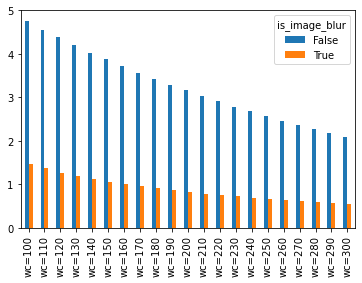

In [5]:
blur_no_log_detection_df.drop("Unnamed: 0", axis = 1, inplace = True)
blur_no_log_detection_df.groupby("is_image_blur").mean().transpose().plot.bar()

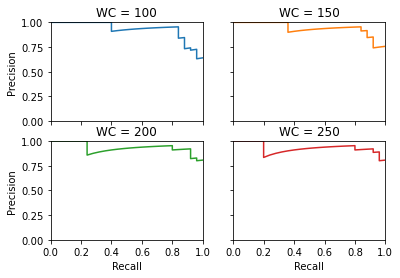

In [6]:
precision1, recall1, thresholds1 = precision_recall_curve(blur_no_log_detection_df["is_image_blur"], -blur_no_log_detection_df["wc=100"])
precision2, recall2, thresholds2 = precision_recall_curve(blur_no_log_detection_df["is_image_blur"], -blur_no_log_detection_df["wc=150"])
precision3, recall3, thresholds3 = precision_recall_curve(blur_no_log_detection_df["is_image_blur"], -blur_no_log_detection_df["wc=200"])
precision4, recall4, thresholds4 = precision_recall_curve(blur_no_log_detection_df["is_image_blur"], -blur_no_log_detection_df["wc=250"])

fig, axs = plt.subplots(2, 2)
axs[0, 0].set_xlim([0,1])
axs[0, 0].set_ylim([0,1])
axs[0, 0].plot(recall1, precision1, 'tab:blue') 
axs[0, 0].set_title('WC = 100')
axs[0, 1].set_xlim([0,1])
axs[0, 1].set_ylim([0,1])
axs[0, 1].plot(recall2, precision2, 'tab:orange')
axs[0, 1].set_title('WC = 150')
axs[1, 0].set_xlim([0,1])
axs[1, 0].set_ylim([0,1])
axs[1, 0].plot(recall3, precision3, 'tab:green')
axs[1, 0].set_title('WC = 200')
axs[1, 1].set_xlim([0,1])
axs[1, 1].set_ylim([0,1])
axs[1, 1].plot(recall4, precision4, 'tab:red')
axs[1, 1].set_title('WC = 250')

for ax in axs.flat:
    ax.set(xlabel='Recall', ylabel='Precision')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [7]:
scores = []
for idx, threshold in enumerate(thresholds4):
    score = f1_score(blur_no_log_detection_df["is_image_blur"], blur_no_log_detection_df["wc=250"] <= -threshold)
    scores.append((score, idx))
print(max(scores))
idx_max = max(scores)[1]
best_threshold = -thresholds4[idx_max]
print(precision4[idx_max])
print(recall4[idx_max])
print(best_threshold)


(0.923076923076923, 3)
0.8888888888888888
0.96
1.2805228893466365


In [8]:
blur_no_log_test_detection_df = run_batch("imageTestDataset", "rectangular", [250])
blur_no_log_test_detection_df

,name,is_image_blur,wc=250
0,imageTestDataset/imagem1.jpg,False,2.343720
1,imageTestDataset/imagem10.jpg,False,3.711094
2,imageTestDataset/imagem10_blur.jpg,True,0.368612
3,imageTestDataset/imagem1_blur.jpg,True,0.881935
4,imageTestDataset/imagem2.jpg,False,2.921248
5,imageTestDataset/imagem2_blur.jpg,True,0.341993
6,imageTestDataset/imagem3_blur.jpg,True,0.541977
7,imageTestDataset/imagem4_blur.jpg,True,0.661075
8,imageTestDataset/imagem5.jpg,False,143.501314
9,imageTestDataset/imagem5_blur.jpg,True,0.581062


In [9]:
blur_no_log_test_detection_df["predicted_blur"] = blur_no_log_test_detection_df["wc=250"] <= best_threshold
blur_no_log_test_detection_df

,name,is_image_blur,wc=250,predicted_blur
0,imageTestDataset/imagem1.jpg,False,2.343720,False
1,imageTestDataset/imagem10.jpg,False,3.711094,False
2,imageTestDataset/imagem10_blur.jpg,True,0.368612,True
3,imageTestDataset/imagem1_blur.jpg,True,0.881935,True
4,imageTestDataset/imagem2.jpg,False,2.921248,False
5,imageTestDataset/imagem2_blur.jpg,True,0.341993,True
6,imageTestDataset/imagem3_blur.jpg,True,0.541977,True
7,imageTestDataset/imagem4_blur.jpg,True,0.661075,True
8,imageTestDataset/imagem5.jpg,False,143.501314,False
9,imageTestDataset/imagem5_blur.jpg,True,0.581062,True


In [10]:
precision_score(blur_no_log_test_detection_df["is_image_blur"], blur_no_log_test_detection_df["predicted_blur"])

1.0

In [11]:
recall_score(blur_no_log_test_detection_df["is_image_blur"], blur_no_log_test_detection_df["predicted_blur"])

1.0

In [14]:
blur_no_log_detection_df["predicted_blur"] = blur_no_log_detection_df["wc=250"] <= best_threshold
blur_no_log_detection_df[blur_no_log_detection_df["predicted_blur"] != blur_no_log_detection_df["is_image_blur"]][["is_image_blur","predicted_blur", "name"]] 

,is_image_blur,predicted_blur,name
24,True,False,imageTrainDataset\imagem20_blur.jpg
36,False,True,imageTrainDataset\imagem27.jpg
50,False,True,imageTrainDataset\imagem39.jpg
55,False,True,imageTrainDataset\imagem42.jpg
